# Analysis of Study Data

Prolific participants only. Auto-detects the export timestamp from CSV files in this directory.


## Setup

In [1]:
# Install required packages (uncomment and run if needed)
#!pip install pandas matplotlib seaborn ipywidgets

# Note: json, glob, os, and html are built-in Python modules — no installation needed


In [2]:
import glob
import json
import os
from html import escape

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from IPython.display import HTML, display

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


### Data Loading and Filtering


In [3]:
# Auto-detect export timestamp from CSV files in this directory
_mod_files = sorted(glob.glob('moderation_sessions_export_*.csv'))
if not _mod_files:
    raise FileNotFoundError(
        "No moderation_sessions_export_*.csv found in current directory. "
        "Run the export script first, then open the notebook from its export folder."
    )

EXPORT_TIMESTAMP = _mod_files[-1].replace('moderation_sessions_export_', '').replace('.csv', '')
print(f"Detected export timestamp: {EXPORT_TIMESTAMP}")

# --- Load all data files ---
moderation_df      = pd.read_csv(f'moderation_sessions_export_{EXPORT_TIMESTAMP}.csv')
child_profiles_df  = pd.read_csv(f'child_profiles_export_{EXPORT_TIMESTAMP}.csv')
exit_quiz_df       = pd.read_csv(f'exit_quiz_responses_export_{EXPORT_TIMESTAMP}.csv')
assignment_time_df = pd.read_csv(f'assignment_time_export_{EXPORT_TIMESTAMP}.csv')

_users_file = f'users_export_{EXPORT_TIMESTAMP}.csv'
if os.path.exists(_users_file):
    users_df = pd.read_csv(_users_file)
else:
    print(f"WARNING: {_users_file} not found — users_df will be empty.")
    users_df = pd.DataFrame()

print(f"\nRaw row counts:")
print(f"  Users:               {len(users_df)}")
print(f"  Moderation sessions: {len(moderation_df)}")
print(f"  Child profiles:      {len(child_profiles_df)}")
print(f"  Exit quiz responses: {len(exit_quiz_df)}")
print(f"  Assignment time:     {len(assignment_time_df)}")

# --- Filter to Prolific participants only (prolific_pid non-null) ---
def _is_prolific(pid):
    return pd.notna(pid) and str(pid).strip() != ''

# Build prolific user-id set from users table if available, else fall back to moderation table
if len(users_df) > 0 and 'prolific_pid' in users_df.columns:
    prolific_user_ids = set(users_df.loc[users_df['prolific_pid'].apply(_is_prolific), 'id'])
else:
    prolific_user_ids = set(
        moderation_df.loc[moderation_df['prolific_pid'].apply(_is_prolific), 'user_id']
    )

moderation_df      = moderation_df[moderation_df['user_id'].isin(prolific_user_ids)].copy()
child_profiles_df  = child_profiles_df[child_profiles_df['user_id'].isin(prolific_user_ids)].copy()
exit_quiz_df       = exit_quiz_df[exit_quiz_df['user_id'].isin(prolific_user_ids)].copy()
assignment_time_df = assignment_time_df[assignment_time_df['user_id'].isin(prolific_user_ids)].copy()
if len(users_df) > 0:
    users_df = users_df[users_df['id'].isin(prolific_user_ids)].copy()

print(f"\nAfter filtering to {len(prolific_user_ids)} Prolific participant(s):")
print(f"  Users:               {len(users_df)}")
print(f"  Moderation sessions: {len(moderation_df)}")
print(f"  Child profiles:      {len(child_profiles_df)}")
print(f"  Exit quiz responses: {len(exit_quiz_df)}")
print(f"  Assignment time:     {len(assignment_time_df)}")


Detected export timestamp: 20260221_184350

Raw row counts:
  Users:               12
  Moderation sessions: 47
  Child profiles:      8
  Exit quiz responses: 7
  Assignment time:     422

After filtering to 11 Prolific participant(s):
  Users:               11
  Moderation sessions: 47
  Child profiles:      8
  Exit quiz responses: 7
  Assignment time:     422


In [4]:
moderation_df.columns

Index(['id', 'user_id', 'child_id', 'scenario_id', 'scenario_index',
       'attempt_number', 'version_number', 'session_number', 'scenario_prompt',
       'original_response', 'initial_decision', 'is_final_version',
       'concern_level', 'concern_reason', 'satisfaction_level',
       'satisfaction_reason', 'next_action', 'decided_at',
       'highlights_saved_at', 'saved_at', 'strategies', 'custom_instructions',
       'highlighted_texts', 'refactored_response', 'session_metadata',
       'is_attention_check', 'attention_check_selected',
       'attention_check_passed', 'created_at', 'updated_at', 'user_name',
       'user_email', 'user_role', 'prolific_pid', 'child_name', 'child_age',
       'child_gender', 'child_characteristics'],
      dtype='object')

In [5]:
# Parse a list of prolific PIDs and filter to only those participants

# Copy-paste your PIDs here (just the IDs, one per line or comma-separated)
def parse_prolific_pids(text_block: str):
    """Extract unique Prolific-style 24-char hex IDs from a mixed text block."""
    seen = set()
    pids = []

    for line in text_block.splitlines():
        s = line.strip()
        if len(s) == 24 and all(ch in "0123456789abcdefABCDEF" for ch in s):
            pid = s.lower()
            if pid not in seen:
                seen.add(pid)
                pids.append(pid)

    return pids


raw_pid_block = """
59347d4f53490b0001563e47
21 Feb 2026, 12:07
00:48:42
UNKNOWN CODE

5eb339ee6290bc124b8549a6
21 Feb 2026, 12:32
00:14:25
UNKNOWN CODE

61219fd8387ca59d07e0dc1c
21 Feb 2026, 12:38
00:22:55
UNKNOWN CODE

607668ac450fc6e3025a131d
21 Feb 2026, 12:53
00:21:00
UNKNOWN CODE

641370f5a8d3826956778170
21 Feb 2026, 16:15
00:25:39
UNKNOWN CODE
"""

pids_to_keep = parse_prolific_pids(raw_pid_block)
print(f"Parsed {len(pids_to_keep)} PID(s): {pids_to_keep}")

# Filter all dataframes to only these prolific participants
filtered_user_ids = set(
    users_df.loc[users_df['prolific_pid'].isin(pids_to_keep), 'id']
)

moderation_df_filtered      = moderation_df[moderation_df['user_id'].isin(filtered_user_ids)].copy()
child_profiles_df_filtered  = child_profiles_df[child_profiles_df['user_id'].isin(filtered_user_ids)].copy()
exit_quiz_df_filtered       = exit_quiz_df[exit_quiz_df['user_id'].isin(filtered_user_ids)].copy()
assignment_time_df_filtered = assignment_time_df[assignment_time_df['user_id'].isin(filtered_user_ids)].copy()
users_df_filtered           = users_df[users_df['id'].isin(filtered_user_ids)].copy()

print(f"Filtered to {len(pids_to_keep)} participant(s):")
print(f"  Users:               {len(users_df_filtered)}")
print(f"  Moderation sessions: {len(moderation_df_filtered)}")
print(f"  Child profiles:      {len(child_profiles_df_filtered)}")
print(f"  Exit quiz responses: {len(exit_quiz_df_filtered)}")
print(f"  Assignment time:     {len(assignment_time_df_filtered)}")

# Reassign to main variables for downstream analysis
moderation_df      = moderation_df_filtered
child_profiles_df  = child_profiles_df_filtered
exit_quiz_df       = exit_quiz_df_filtered
assignment_time_df = assignment_time_df_filtered
users_df           = users_df_filtered

Parsed 5 PID(s): ['59347d4f53490b0001563e47', '5eb339ee6290bc124b8549a6', '61219fd8387ca59d07e0dc1c', '607668ac450fc6e3025a131d', '641370f5a8d3826956778170']
Filtered to 5 participant(s):
  Users:               5
  Moderation sessions: 35
  Child profiles:      5
  Exit quiz responses: 5
  Assignment time:     289


In [6]:
# Schema guard & normalization — handles minor column changes between export versions
print("Schema check:")
for _name, _df in [
    ('moderation_df',      moderation_df),
    ('child_profiles_df',  child_profiles_df),
    ('exit_quiz_df',       exit_quiz_df),
    ('assignment_time_df', assignment_time_df),
    ('users_df',           users_df),
]:
    print(f"  {_name}: {len(_df)} rows, {len(_df.columns)} columns")

# Ensure all columns the analysis relies on exist in moderation_df
_mod_required = [
    'prolific_pid', 'user_id', 'session_number', 'scenario_index', 'strategies',
    'session_metadata', 'original_response', 'initial_decision', 'refactored_response',
    'custom_instructions', 'child_name', 'child_age', 'id', 'is_attention_check',
    'concern_level', 'concern_reason', 'highlighted_texts', 'is_final_version',
    'scenario_prompt',
]
for _c in _mod_required:
    if _c not in moderation_df.columns:
        print(f"  Adding missing column '{_c}' to moderation_df (filled with None)")
        moderation_df[_c] = None

# Normalize JSON-serialized text columns so downstream parsing is safe
moderation_df['strategies']        = moderation_df['strategies'].fillna('[]').astype(str)
moderation_df['session_metadata']  = moderation_df['session_metadata'].fillna('').astype(str)
moderation_df['highlighted_texts'] = moderation_df['highlighted_texts'].fillna('[]').astype(str)

# Coerce numeric columns
for _col in ['concern_level', 'satisfaction_level', 'scenario_index',
             'session_number', 'is_attention_check', 'is_final_version']:
    if _col in moderation_df.columns:
        moderation_df[_col] = pd.to_numeric(moderation_df[_col], errors='coerce')

print("\nNormalization complete.")


Schema check:
  moderation_df: 35 rows, 38 columns
  child_profiles_df: 5 rows, 21 columns
  exit_quiz_df: 5 rows, 17 columns
  assignment_time_df: 289 rows, 10 columns
  users_df: 5 rows, 17 columns

Normalization complete.


## Time Spent Per Session


In [7]:
# Time spent per participant per session
# active_ms_delta = time since last heartbeat ping (most reliable for true active time)
# cumulative_ms   = running total reported by the client

_tmp = assignment_time_df.copy()
_tmp['active_ms_delta'] = pd.to_numeric(_tmp['active_ms_delta'], errors='coerce').fillna(0)
_tmp['cumulative_ms']   = pd.to_numeric(_tmp['cumulative_ms'],   errors='coerce').fillna(0)

time_by_user_session = (
    _tmp.groupby(['user_id', 'prolific_pid', 'session_number'], dropna=False)
        .agg(
            events            = ('id',              'count'),
            total_active_ms   = ('active_ms_delta', 'sum'),
            max_cumulative_ms = ('cumulative_ms',   'max'),
            first_event_at    = ('created_at',      'min'),
            last_event_at     = ('created_at',      'max'),
        )
        .reset_index()
)

time_by_user_session['total_active_minutes']   = time_by_user_session['total_active_ms']   / 60_000
time_by_user_session['max_cumulative_minutes'] = time_by_user_session['max_cumulative_ms'] / 60_000
time_by_user_session = time_by_user_session.sort_values(['prolific_pid', 'session_number'])

print("Time spent per participant per session:\n")
print(
    time_by_user_session[
        ['prolific_pid', 'session_number', 'events',
         'total_active_minutes', 'max_cumulative_minutes']
    ].to_string(index=False)
)


Time spent per participant per session:

            prolific_pid  session_number  events  total_active_minutes  max_cumulative_minutes
59347d4f53490b0001563e47               1     103             13.300000               13.300000
5eb339ee6290bc124b8549a6               1      33             12.466667               12.466667
607668ac450fc6e3025a131d               1      47             19.466667               19.466667
61219fd8387ca59d07e0dc1c               1      51             21.466667               21.466667
641370f5a8d3826956778170               1      55             21.400000               21.400000


## Time Distribution


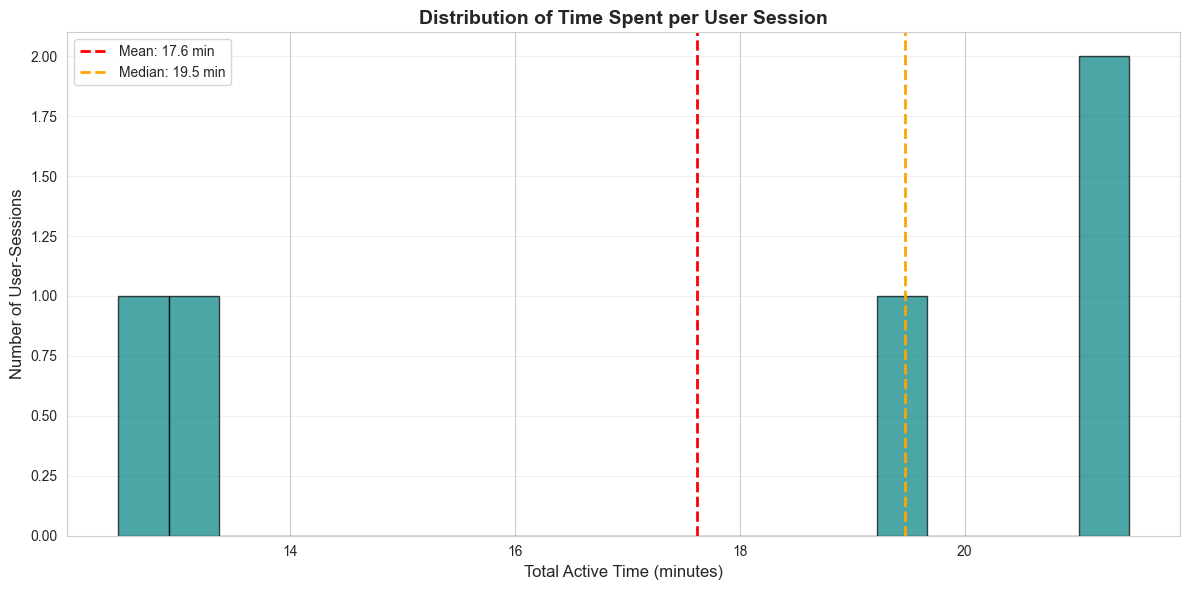


Time per user-session statistics (active time):
count     5.000000
mean     17.620000
std       4.407796
min      12.466667
25%      13.300000
50%      19.466667
75%      21.400000
max      21.466667
Name: total_active_minutes, dtype: float64

Total number of user-sessions: 5


In [8]:
# Plot distribution of time spent per user
# Note: Uses time_by_user_session which aggregates total active time per user per session
if len(time_by_user_session) > 0:
    plt.figure(figsize=(12, 6))
    plt.hist(time_by_user_session['total_active_minutes'], bins=20, color='teal', edgecolor='black', alpha=0.7)
    plt.xlabel('Total Active Time (minutes)', fontsize=12)
    plt.ylabel('Number of User-Sessions', fontsize=12)
    plt.title('Distribution of Time Spent per User Session', fontsize=14, fontweight='bold')
    plt.axvline(time_by_user_session['total_active_minutes'].mean(), color='red', linestyle='--', 
                label=f"Mean: {time_by_user_session['total_active_minutes'].mean():.1f} min", linewidth=2)
    plt.axvline(time_by_user_session['total_active_minutes'].median(), color='orange', linestyle='--', 
                label=f"Median: {time_by_user_session['total_active_minutes'].median():.1f} min", linewidth=2)
    plt.legend()
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nTime per user-session statistics (active time):")
    stats = time_by_user_session['total_active_minutes'].describe()
    print(stats)
    print(f"\nTotal number of user-sessions: {len(time_by_user_session)}")
else:
    print("No time data available.")


In [9]:
# Per-participant median active time across their sessions
per_user_time = (
    time_by_user_session
    .groupby('prolific_pid', dropna=False)['total_active_minutes']
    .agg(sessions='count', median_min='median', mean_min='mean', total_min='sum')
    .reset_index()
    .sort_values('median_min', ascending=False)
    .rename(columns={
        'prolific_pid': 'prolific_pid',
        'sessions':     'sessions',
        'median_min':   'median_active_min',
        'mean_min':     'mean_active_min',
        'total_min':    'total_active_min',
    })
)

print("Per-participant time summary (sorted by median active minutes):\n")
print(per_user_time.to_string(index=False))
print(f"\nOverall median across all user-sessions: "
      f"{time_by_user_session['total_active_minutes'].median():.2f} min")


Per-participant time summary (sorted by median active minutes):

            prolific_pid  sessions  median_active_min  mean_active_min  total_active_min
61219fd8387ca59d07e0dc1c         1          21.466667        21.466667         21.466667
641370f5a8d3826956778170         1          21.400000        21.400000         21.400000
607668ac450fc6e3025a131d         1          19.466667        19.466667         19.466667
59347d4f53490b0001563e47         1          13.300000        13.300000         13.300000
5eb339ee6290bc124b8549a6         1          12.466667        12.466667         12.466667

Overall median across all user-sessions: 19.47 min


## Attention Check Results


In [10]:
# Attention check pass/fail per participant.
# A row passes when BOTH conditions are true:
#   1. highlighted_texts is non-empty  (user highlighted something)
#   2. concern_reason contains "attention check" (case-insensitive)

def _has_highlight(x):
    """Return True if x is a non-empty highlights value."""
    if pd.isna(x):
        return False
    s = str(x).strip()
    if s in ('', '[]', 'nan'):
        return False
    try:
        parsed = json.loads(s)
        return bool(parsed) if isinstance(parsed, (list, dict)) else False
    except Exception:
        return len(s) > 0

attn = moderation_df[moderation_df['is_attention_check'] == 1].copy()
attn['has_highlight']         = attn['highlighted_texts'].apply(_has_highlight)
attn['typed_attention_check'] = (
    attn['concern_reason']
    .fillna('')
    .astype(str)
    .str.lower()
    .str.contains('attention check', na=False)
)
attn['passed'] = attn['has_highlight'] & attn['typed_attention_check']

diag_cols = [
    'prolific_pid', 'session_number', 'scenario_index',
    'has_highlight', 'typed_attention_check', 'passed',
    'concern_level', 'concern_reason',
]
print("Attention-check rows:\n")
print(
    attn[[c for c in diag_cols if c in attn.columns]]
    .sort_values(['prolific_pid', 'session_number', 'scenario_index'])
    .to_string(index=False)
)

total  = len(attn)
n_pass = int(attn['passed'].sum())
if total > 0:
    print(f"\nSummary: {n_pass} / {total} attention-check rows passed "
          f"({100 * n_pass / total:.1f}% pass rate)")
else:
    print("\nNo attention-check rows found.")


Attention-check rows:

            prolific_pid  session_number  scenario_index  has_highlight  typed_attention_check  passed  concern_level  concern_reason
59347d4f53490b0001563e47               1               2           True                  False   False            NaN             NaN
5eb339ee6290bc124b8549a6               1               1          False                  False   False            NaN             NaN
607668ac450fc6e3025a131d               1               5           True                  False   False            NaN             NaN
61219fd8387ca59d07e0dc1c               1               4           True                  False   False            NaN             NaN
641370f5a8d3826956778170               1               1           True                  False   False            NaN             NaN

Summary: 0 / 5 attention-check rows passed (0.0% pass rate)


In [11]:
# Re-filter all dataframes to participants who passed the attention check
#_passed_user_ids = set(attn.loc[attn['passed'] == True, 'user_id'])

# for this version, we are manually overriding the passed user IDs based on the known PIDs from the attention check block above
_passed_user_ids = set(attn.loc[attn['has_highlight'] == True, 'user_id'])


moderation_df      = moderation_df[moderation_df['user_id'].isin(_passed_user_ids)].copy()
child_profiles_df  = child_profiles_df[child_profiles_df['user_id'].isin(_passed_user_ids)].copy()
exit_quiz_df       = exit_quiz_df[exit_quiz_df['user_id'].isin(_passed_user_ids)].copy()
assignment_time_df = assignment_time_df[assignment_time_df['user_id'].isin(_passed_user_ids)].copy()
users_df           = users_df[users_df['id'].isin(_passed_user_ids)].copy()

print(f"Kept {len(_passed_user_ids)} participant(s) who passed the attention check.")
print(f"  Moderation sessions: {len(moderation_df)}")
print(f"  Child profiles:      {len(child_profiles_df)}")
print(f"  Exit quiz responses: {len(exit_quiz_df)}")
print(f"  Assignment time:     {len(assignment_time_df)}")
print(f"  Users:               {len(users_df)}")


Kept 4 participant(s) who passed the attention check.
  Moderation sessions: 28
  Child profiles:      4
  Exit quiz responses: 4
  Assignment time:     256
  Users:               4


## Skips vs Highlighted Scenarios

A **skip** is any final-version scenario where `highlighted_texts` is empty or `[]`. Attention-check scenarios are excluded.


In [12]:
# Restrict to final-version rows, excluding attention checks
final = moderation_df[
    (moderation_df['is_attention_check'] != 1)
].copy()
final['is_highlighted'] = final['highlighted_texts'].apply(_has_highlight)
final['is_skip']        = ~final['is_highlighted']

total_final   = len(final)
n_highlighted = int(final['is_highlighted'].sum())
n_skipped     = int(final['is_skip'].sum())
pct_hi        = 100 * n_highlighted / total_final if total_final > 0 else 0

print("Overall (final-version scenarios, excluding attention checks):")
print(f"  Total scenarios    : {total_final}")
print(f"  Highlighted        : {n_highlighted}  ({pct_hi:.1f}%)")
print(f"  Skipped            : {n_skipped}  ({100 - pct_hi:.1f}%)")


Overall (final-version scenarios, excluding attention checks):
  Total scenarios    : 24
  Highlighted        : 8  (33.3%)
  Skipped            : 16  (66.7%)


In [13]:
# Per-participant breakdown
# If explicit final-version rows are empty, fall back to latest row per (user_id, scenario_index)
if final.empty:
    final_for_skip = (
        moderation_df[moderation_df['is_attention_check'] != 1]
        .sort_values(['user_id', 'scenario_index', 'created_at'])
        .groupby(['user_id', 'scenario_index'], as_index=False, dropna=False)
        .tail(1)
        .copy()
    )
    final_for_skip['is_highlighted'] = final_for_skip['highlighted_texts'].apply(_has_highlight)
    final_for_skip['is_skip'] = ~final_for_skip['is_highlighted']
else:
    final_for_skip = final.copy()

per_user_skip = (
    final_for_skip.groupby('prolific_pid', dropna=False)
    .agg(
        total=('id', 'count'),
        highlighted=('is_highlighted', 'sum'),
        skipped=('is_skip', 'sum'),
    )
    .reset_index()
)

for _c in ['total', 'highlighted', 'skipped']:
    per_user_skip[_c] = pd.to_numeric(per_user_skip[_c], errors='coerce').fillna(0)

per_user_skip['pct_highlighted'] = (
    100 * per_user_skip['highlighted'] / per_user_skip['total'].replace(0, pd.NA)
).fillna(0).round(1)

per_user_skip = per_user_skip.sort_values('pct_highlighted', ascending=False)

print("Per-participant skip vs highlight (final-version, excluding attention checks):\n")
print(per_user_skip.to_string(index=False))


Per-participant skip vs highlight (final-version, excluding attention checks):

            prolific_pid  total  highlighted  skipped  pct_highlighted
61219fd8387ca59d07e0dc1c      6            5        1             83.3
607668ac450fc6e3025a131d      6            2        4             33.3
641370f5a8d3826956778170      6            1        5             16.7
59347d4f53490b0001563e47      6            0        6              0.0


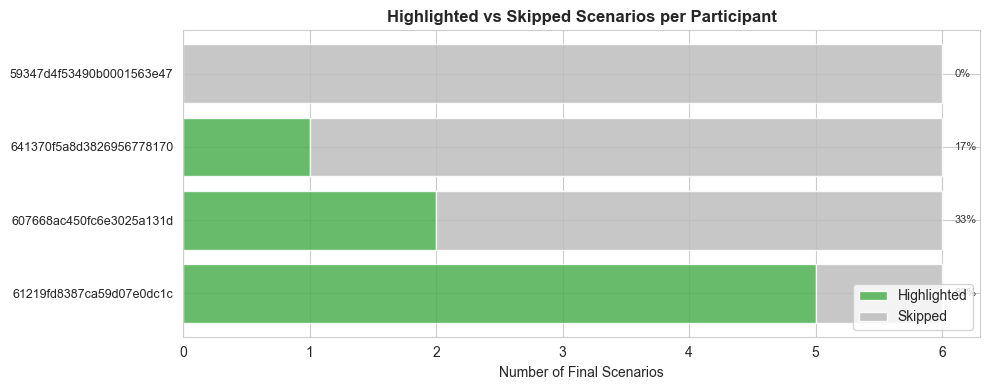

In [14]:
# Stacked horizontal bar chart — highlighted (green) vs skipped (gray) per participant
#_sorted = per_user_skip.sort_values('pct_highlighted', ascending=True)

fig, ax = plt.subplots(figsize=(10, max(4, len(per_user_skip) * 0.5 + 1.5)))

pids    = per_user_skip['prolific_pid'].fillna('(no pid)').astype(str).tolist()
hi_vals = per_user_skip['highlighted'].tolist()
sk_vals = per_user_skip['skipped'].tolist()
y_pos   = list(range(len(pids)))

ax.barh(y_pos, hi_vals,              color='#4caf50', label='Highlighted', alpha=0.85)
ax.barh(y_pos, sk_vals, left=hi_vals, color='#bdbdbd', label='Skipped',    alpha=0.85)

# Annotate pct highlighted at the right edge of each bar
for i, (row) in enumerate(per_user_skip.itertuples()):
    ax.text(
        row.total + 0.1, i,
        f"{row.pct_highlighted:.0f}%",
        va='center', fontsize=8, color='#333',
    )

ax.set_yticks(y_pos)
ax.set_yticklabels(pids, fontsize=9)
ax.set_xlabel('Number of Final Scenarios')
ax.set_title('Highlighted vs Skipped Scenarios per Participant', fontweight='bold')
ax.legend(loc='lower right')
plt.tight_layout()
plt.show()


## Exit Survey Summary

Frequency counts for each survey question, with median highlight count per participant shown alongside each response category so you can see whether a demographic trait correlates with highlighting behaviour.


In [15]:
import json
import pandas as pd

# ── Exit Survey Summary ──────────────────────────────────────────────────────
# Parse the JSON `answers` blob into flat columns, then summarise each question.
# For each category value we show: count of participants AND their median
# highlight count.


# 1. Parse answers JSON
eq = exit_quiz_df.copy()
eq['_answers'] = eq['answers'].apply(
    lambda x: json.loads(x) if pd.notna(x) and str(x).strip() else {}
)

def _as_scalar(v):
    # Keep true scalars as-is; unwrap simple one-item lists; stringify complex values
    if isinstance(v, list):
        if len(v) == 0:
            return pd.NA
        if len(v) == 1:
            return v[0]
        return " | ".join(map(str, v))
    if isinstance(v, dict):
        return json.dumps(v, sort_keys=True)
    return v

def _as_list(v):
    if isinstance(v, list):
        return v
    if pd.isna(v):
        return []
    # If value is a JSON-encoded list string, parse it
    if isinstance(v, str):
        s = v.strip()
        if s.startswith("[") and s.endswith("]"):
            try:
                parsed = json.loads(s)
                return parsed if isinstance(parsed, list) else [str(v)]
            except Exception:
                pass
    return [v]

# Flatten scalar answer fields into columns
SCALAR_FIELDS = [
    'parentGender', 'parentAge', 'areaOfResidency', 'parentEducation',
    'genaiFamiliarity', 'genaiUsageFrequency', 'parentingStyle',
    'isOnlyChild', 'childHasAIUse', 'parentLLMMonitoringLevel',
    'parentInternetUseFrequency', 'childInternetUseFrequency',
]
for f in SCALAR_FIELDS:
    eq[f] = eq['_answers'].apply(lambda d: _as_scalar(d.get(f)))

# Multi-select list fields
MULTI_FIELDS = ['parentEthnicity', 'childAIUseContexts', 'childPersonalitySubCharacteristics']
for f in MULTI_FIELDS:
    eq[f] = eq['_answers'].apply(lambda d: _as_list(d.get(f, [])))

# 2. Compute per-participant highlight count from moderation table
_src = moderation_df_filtered.copy() if 'moderation_df_filtered' in globals() else moderation_df.copy()
_hi_counts = _src[_src['is_attention_check'] != 1].copy()
_hi_counts['has_highlight'] = _hi_counts['highlighted_texts'].apply(_has_highlight)

highlights_per_user = (
    _hi_counts.groupby('user_id', dropna=False)['has_highlight']
    .sum()
    .reset_index()
    .rename(columns={'has_highlight': 'n_highlights'})
)

# Join highlight counts onto the exit-quiz table
eq = eq.merge(highlights_per_user, on='user_id', how='left')
eq['n_highlights'] = eq['n_highlights'].fillna(0).astype(int)

print(f"Exit survey rows: {len(eq)}")
print(f"Highlight counts attached: {eq['n_highlights'].tolist()}")

def _to_hashable(v):
    if isinstance(v, list):
        return tuple(v)
    if isinstance(v, dict):
        return json.dumps(v, sort_keys=True)
    return v

# 3. Helper: summarise a single-value column
def _summarise_single(col_name, label=None):
    label = label or col_name

    tmp = eq[[col_name, 'user_id', 'n_highlights']].copy()
    tmp['value'] = tmp[col_name].apply(_to_hashable)
    tmp['value'] = tmp['value'].where(tmp['value'].notna(), '(missing)')

    grp = (
        tmp.groupby('value', dropna=False)
        .agg(
            count=('user_id', 'count'),
            median_highlights=('n_highlights', 'median'),
            mean_highlights=('n_highlights', 'mean'),
        )
        .reset_index()
        .sort_values('count', ascending=False)
    )
    grp['median_highlights'] = grp['median_highlights'].round(1)
    grp['mean_highlights'] = grp['mean_highlights'].round(1)

    print(f"\n{'='*60}")
    print(f"  {label}")
    print(f"{'='*60}")
    print(grp[['value', 'count', 'median_highlights', 'mean_highlights']].to_string(index=False))

# 4. Helper: summarise a multi-select (list) column
def _summarise_multi(col_name, label=None):
    label = label or col_name
    _rows = []
    for _, r in eq.iterrows():
        vals = _as_list(r[col_name])
        if len(vals) == 0:
            _rows.append({'value': '(none)', 'n_highlights': r['n_highlights']})
        else:
            for v in vals:
                _rows.append({'value': _to_hashable(v), 'n_highlights': r['n_highlights']})

    _exp = pd.DataFrame(_rows)
    grp = (
        _exp.groupby('value', dropna=False)
        .agg(
            count=('n_highlights', 'count'),
            median_highlights=('n_highlights', 'median'),
            mean_highlights=('n_highlights', 'mean'),
        )
        .reset_index()
        .sort_values('count', ascending=False)
    )
    grp['median_highlights'] = grp['median_highlights'].round(1)
    grp['mean_highlights'] = grp['mean_highlights'].round(1)

    print(f"\n{'='*60}")
    print(f"  {label}  [multi-select — counts are participant×option]")
    print(f"{'='*60}")
    print(grp[['value', 'count', 'median_highlights', 'mean_highlights']].to_string(index=False))

# ── Demographic questions ────────────────────────────────────────────────────
_summarise_single('parentGender',              'Parent Gender')
_summarise_single('parentAge',                 'Parent Age Group')
_summarise_single('areaOfResidency',           'Area of Residency')
_summarise_single('parentEducation',           'Parent Education Level')
_summarise_multi ('parentEthnicity',           'Parent Ethnicity (multi-select)')

# ── GenAI familiarity ────────────────────────────────────────────────────────
_summarise_single('genaiFamiliarity',          'GenAI Familiarity')
_summarise_single('genaiUsageFrequency',       'GenAI Usage Frequency')
_summarise_single('parentInternetUseFrequency','Parent Internet Use Frequency (1-10)')

# ── Parenting & child AI use ─────────────────────────────────────────────────
_summarise_single('parentingStyle',            'Parenting Style')
_summarise_single('isOnlyChild',               'Is Only Child')
_summarise_single('childHasAIUse',             'Child Has AI Use')
_summarise_multi ('childAIUseContexts',        'Child AI Use Contexts (multi-select)')
_summarise_single('parentLLMMonitoringLevel',  'Parent LLM Monitoring Level')
_summarise_single('childInternetUseFrequency', 'Child Internet Use Frequency (1-10)')

# ── Overall highlight summary ────────────────────────────────────────────────
print(f"\n{'='*60}")
print("  Highlights per participant (summary)")
print(f"{'='*60}")
print(eq[['prolific_pid', 'n_highlights']].to_string(index=False))
print(f"\nMean highlights: {eq['n_highlights'].mean():.1f}")
print(f"Median highlights: {eq['n_highlights'].median():.1f}")


Exit survey rows: 4
Highlight counts attached: [2, 5, 0, 1]

  Parent Gender
 value  count  median_highlights  mean_highlights
female      2                3.0              3.0
  male      2                1.0              1.0

  Parent Age Group
value  count  median_highlights  mean_highlights
35-44      2                0.5              0.5
45-54      1                2.0              2.0
55-64      1                5.0              5.0

  Area of Residency
   value  count  median_highlights  mean_highlights
suburban      2                3.5              3.5
   urban      2                0.5              0.5

  Parent Education Level
       value  count  median_highlights  mean_highlights
some-college      2                0.5              0.5
   bachelors      1                5.0              5.0
    doctoral      1                2.0              2.0

  Parent Ethnicity (multi-select)  [multi-select — counts are participant×option]
                 value  count  median_highlight

## Highlights by Scenario Characteristics

For each scenario-level characteristic (`trait`, `polarity`, `prompt_style`, `domain`, `age_band`, `trait_level`) show median and mean highlight counts — so you can see which kinds of scenarios attract more concern.

Below that, a cross-tab shows the same breakdown split by parent demographic, making it easy to spot whether a particular parent trait drives the difference.


In [19]:

# ── Load scenarios CSV ───────────────────────────────────────────────────────
_scenarios_file = f'scenarios_export_{EXPORT_TIMESTAMP}.csv'
if os.path.exists(_scenarios_file):
    scenarios_df = pd.read_csv(_scenarios_file)
    print(f"Loaded {len(scenarios_df)} scenarios.")
else:
    print(f"WARNING: {_scenarios_file} not found. Re-run the export script to get it.")
    scenarios_df = pd.DataFrame()

# ── Join moderation rows to scenario metadata ────────────────────────────────
# moderation_df has a scenario_id column (populated by the export script).
# We join on that; rows without a match still appear (scenario cols will be NaN).
_mod = moderation_df[moderation_df['is_attention_check'] != 1].copy()
_mod['has_highlight'] = _mod['highlighted_texts'].apply(_has_highlight)

if not scenarios_df.empty and 'scenario_id' in _mod.columns:
    _joined = _mod.merge(
        scenarios_df[['scenario_id', 'trait', 'polarity', 'prompt_style',
                      'domain', 'subdomain', 'age_band', 'trait_level']],
        on='scenario_id',
        how='left',
    )
else:
    _joined = _mod.copy()
    for _c in ['trait', 'polarity', 'prompt_style', 'domain',
               'subdomain', 'age_band', 'trait_level']:
        if _c not in _joined.columns:
            _joined[_c] = pd.NA

print(f"Joined rows: {len(_joined)}  |  "
      f"matched to scenario: {_joined['trait'].notna().sum()}")

# ── Per-scenario highlight counts (one row per moderation session) ────────────
# Aggregate so each (user, scenario_id) counts once — use the last saved row.
_deduped = (
    _joined
    .sort_values(['user_id', 'scenario_id', 'updated_at'], na_position='first')
    .groupby(['user_id', 'prolific_pid', 'scenario_id',
              'trait', 'polarity', 'prompt_style',
              'domain', 'subdomain', 'age_band', 'trait_level'],
             dropna=False)
    .agg(highlighted=('has_highlight', 'max'))
    .reset_index()
)

# ── Helper: summarise a scenario characteristic column ───────────────────────
SCENARIO_CHARS = [
    ('trait',        'Trait (Big-Five dimension)'),
    ('polarity',     'Polarity (positive/negative/neutral)'),
    ('prompt_style', 'Prompt Style'),
    ('domain',       'Domain'),
    ('subdomain',    'Subdomain'),
    ('age_band',     'Age Band'),
    ('trait_level',  'Trait Level (high/low)'),
]

def _scenario_summary(col, label):
    grp = (
        _deduped.groupby(col, dropna=False)
        .agg(
            n_scenarios=('scenario_id', 'nunique'),
            n_user_sessions=('user_id', 'count'),
            n_highlighted=('highlighted', 'sum'),
            median_highlighted=('highlighted', 'median'),
            mean_highlighted=('highlighted', 'mean'),
        )
        .reset_index()
        .rename(columns={col: 'value'})
        .sort_values('n_user_sessions', ascending=False)
    )
    grp['pct_highlighted'] = (
        100 * grp['n_highlighted'] / grp['n_user_sessions'].replace(0, pd.NA)
    ).fillna(0).round(1)
    grp['mean_highlighted'] = grp['mean_highlighted'].round(2)
    print(f"\n{'='*70}")
    print(f"  {label}")
    print(f"{'='*70}")
    print(grp[['value', 'n_scenarios', 'n_user_sessions',
               'n_highlighted', 'pct_highlighted']].to_string(index=False))

for _col, _lbl in SCENARIO_CHARS:
    if _col in _deduped.columns:
        _scenario_summary(_col, _lbl)

# # ── Cross-tab: parent characteristic × scenario characteristic ───────────────
# # Use 'eq' from the Exit Survey section (contains per-parent data + n_highlights).
# # We join parent demographic back to the per-scenario data.

# print(f"\n\n{'#'*70}")
# print("  CROSS-TAB: Parent Characteristic × Scenario Characteristic")
# print(f"{'#'*70}")

# # Build a per-(user, scenario) table with parent demographics attached
# _parent_cols = [
#     ('parentAge',                'Parent Age',          False),
#     ('genaiFamiliarity',         'GenAI Familiarity',   False),
#     ('genaiUsageFrequency',      'GenAI Usage Freq',    False),
#     ('parentLLMMonitoringLevel', 'Parent LLM Monitor',  False),
#     ('parentEthnicity',          'Parent Ethnicity',    True),   # multi-select
#     ('childHasAIUse',            'Child Has AI Use',    False),
# ]

# # eq is defined in the Exit Survey cell — guard in case cell order differs
# if 'eq' not in dir() and 'eq' not in globals():
#     print("WARNING: 'eq' (exit quiz DataFrame) not found. "
#           "Run the Exit Survey Summary cell first.")
# else:
#     # Flatten parent demographics for the join (use scalar fields; explode multi-selects)
#     _eq_slim = eq[['user_id'] + [c for c, _, _ in _parent_cols]].copy()

#     for _pc, _plbl, _is_multi in _parent_cols:
#         if _pc not in _eq_slim.columns:
#             continue
#         _sub = _deduped.merge(_eq_slim[['user_id', _pc]], on='user_id', how='left')
#         unique_parents = _sub['user_id'].nunique()
#         print(f"\n{'─'*70}")
#         print(f"  Parent: {_plbl}  ×  Scenario characteristics  "
#               f"(n={unique_parents} participants)")
#         print(f"{'─'*70}")

#         for _sc, _slbl in SCENARIO_CHARS:
#             if _sc not in _sub.columns:
#                 continue
#             if _is_multi:
#                 # Explode comma-separated parent values before grouping
#                 _exploded = []
#                 for _, r in _sub.iterrows():
#                     pvals = r[_pc] if isinstance(r[_pc], list) else (
#                         [] if pd.isna(r[_pc]) else [r[_pc]]
#                     )
#                     if not pvals:
#                         pvals = ['(none)']
#                     for pv in pvals:
#                         _exploded.append({
#                             'parent_val':  str(pv),
#                             'scenario_val': str(r[_sc]) if pd.notna(r[_sc]) else '(unknown)',
#                             'highlighted': r['highlighted'],
#                         })
#                 _ct = pd.DataFrame(_exploded)
#             else:
#                 _ct = _sub[[_pc, _sc, 'highlighted']].copy()
#                 _ct = _ct.rename(columns={_pc: 'parent_val', _sc: 'scenario_val'})
#                 _ct['parent_val']   = _ct['parent_val'].fillna('(missing)').astype(str)
#                 _ct['scenario_val'] = _ct['scenario_val'].fillna('(unknown)').astype(str)

#             if _ct.empty:
#                 continue

#             _pivot = (
#                 _ct.groupby(['scenario_val', 'parent_val'])
#                 .agg(n=('highlighted', 'count'), pct_hi=('highlighted', 'mean'))
#                 .reset_index()
#             )
#             _pivot['pct_hi'] = (_pivot['pct_hi'] * 100).round(1)
#             _pivot_wide = _pivot.pivot(
#                 index='scenario_val', columns='parent_val', values='pct_hi'
#             ).fillna(0).round(1)

#             print(f"\n  {_slbl}  — % of sessions highlighted  (rows = scenario value, cols = parent value)")
#             print(_pivot_wide.to_string())


Loaded 50 scenarios.
Joined rows: 24  |  matched to scenario: 20

  Trait (Big-Five dimension)
            value  n_scenarios  n_user_sessions  n_highlighted  pct_highlighted
    Agreeableness            5                6              2             33.3
      Neuroticism            3                5              2             40.0
Conscientiousness            4                4              2             50.0
              NaN            4                4              1             25.0
         Openness            3                3              1             33.3
     Extraversion            2                2              0              0.0

  Polarity (positive/negative/neutral)
 value  n_scenarios  n_user_sessions  n_highlighted  pct_highlighted
   NaN           21               24              8             33.3

  Prompt Style
 value  n_scenarios  n_user_sessions  n_highlighted  pct_highlighted
   NaN           21               24              8             33.3

  Domain
   

## Highlight Replay Tool

Select a participant and scenario index to see the original AI response with their highlights applied — replicating the webapp view.


In [17]:
def _parse_highlights(raw):
    """Parse highlights from the CSV (JSON string, list, or None) → list."""
    if isinstance(raw, list):
        return raw
    if pd.isna(raw):
        return []
    s = str(raw).strip()
    if not s or s == '[]':
        return []
    try:
        parsed = json.loads(s)
        return parsed if isinstance(parsed, list) else [parsed]
    except Exception:
        return [s]  # treat as a literal string to match


def render_highlighted_scenario(text, highlights):
    """
    Render *text* with *highlights* applied as <mark> spans.

    highlights may be:
    - a JSON string or list of dicts with {start, end} character indices
    - a list of plain strings (literal substring matches)
    - None / empty → returns plain escaped text
    """
    text = '' if text is None else str(text)
    highlights = _parse_highlights(highlights) if not isinstance(highlights, list) else highlights

    ranges = []

    # Index-range dicts: {"start": N, "end": M}
    for h in highlights:
        if isinstance(h, dict):
            a = h.get('start', h.get('start_idx', h.get('from')))
            b = h.get('end',   h.get('end_idx',   h.get('to')))
            if a is not None and b is not None:
                try:
                    a, b = int(a), int(b)
                    if a < b and 0 <= a < len(text):
                        ranges.append((a, min(b, len(text))))
                except Exception:
                    pass

    # Literal string matches
    for h in highlights:
        if isinstance(h, str) and h:
            pos = 0
            while True:
                i = text.find(h, pos)
                if i == -1:
                    break
                ranges.append((i, i + len(h)))
                pos = i + len(h)

    if not ranges:
        return (
            "<pre style='white-space:pre-wrap;line-height:1.6;"
            "font-family:inherit;margin:0'>"
            f"{escape(text)}</pre>"
        )

    # Merge overlapping/adjacent ranges
    ranges.sort()
    merged = []
    for a, b in ranges:
        if not merged or a > merged[-1][1]:
            merged.append([a, b])
        else:
            merged[-1][1] = max(merged[-1][1], b)

    parts, last = [], 0
    for a, b in merged:
        if last < a:
            parts.append(escape(text[last:a]))
        parts.append(
            f"<mark style='background:#fff59d;padding:0 2px'>"
            f"{escape(text[a:b])}</mark>"
        )
        last = b
    if last < len(text):
        parts.append(escape(text[last:]))

    return (
        "<pre style='white-space:pre-wrap;line-height:1.6;"
        "font-family:inherit;margin:0'>"
        + ''.join(parts)
        + "</pre>"
    )


In [18]:

# Interactive highlight replay
# Shows the scenario prompt and the original AI response with the user's highlights applied.

_replay_df = moderation_df[moderation_df['is_attention_check'] != 1].copy()
_pid_opts  = sorted(_replay_df['prolific_pid'].dropna().unique().tolist())

pid_dd = widgets.Dropdown(
    options     = _pid_opts,
    value       = _pid_opts[0] if _pid_opts else None,
    description = 'Participant:',
    style       = {'description_width': '90px'},
    layout      = widgets.Layout(width='440px'),
)

scenario_dd = widgets.Dropdown(
    options     = [],
    description = 'Scenario #:',
    style       = {'description_width': '90px'},
    layout      = widgets.Layout(width='180px'),
)

out = widgets.Output()


def _refresh_scenarios(change=None):
    pid = pid_dd.value
    if pid is None:
        scenario_dd.options = []
        return
    indices = (
        _replay_df.loc[_replay_df['prolific_pid'] == pid, 'scenario_index']
        .dropna()
        .astype(int)
        .unique()
        .tolist()
    )
    scenario_dd.options = sorted(indices)
    if indices:
        scenario_dd.value = sorted(indices)[0]


def _render(change=None):
    out.clear_output(wait=True)
    pid = pid_dd.value
    idx = scenario_dd.value
    if pid is None or idx is None:
        return

    subset = _replay_df[
        (_replay_df['prolific_pid'] == pid) &
        (_replay_df['scenario_index'] == idx)
    ]
    if subset.empty:
        with out:
            print("No data for this selection.")
        return

    row        = subset.iloc[-1]
    prompt     = str(row.get('scenario_prompt') or '')
    response   = str(row.get('original_response') or '')
    highlights = row.get('highlighted_texts', '[]')
    decision   = row.get('initial_decision',  '—')
    concern    = row.get('concern_level',      '—')
    reason     = str(row.get('concern_reason', '') or '')

    reason_html = (
        f"<br><b>Concern reason:</b> {escape(reason)}"
        if reason and reason != 'nan' else ''
    )
    header = (
        "<div style='font-family:sans-serif;font-size:13px;"
        "border-bottom:1px solid #ddd;padding-bottom:6px;margin-bottom:8px'>"
        f"<b>Participant:</b> {escape(str(pid))} &nbsp;|&nbsp; "
        f"<b>Scenario index:</b> {idx} &nbsp;|&nbsp; "
        f"<b>Decision:</b> {escape(str(decision))} &nbsp;|&nbsp; "
        f"<b>Concern level:</b> {escape(str(concern))}"
        f"{reason_html}"
        "</div>"
    )

    prompt_section = ""
    if prompt:
        prompt_section = (
            "<div style='margin-bottom:12px'>"
            "<div style='font-family:sans-serif;font-size:12px;font-weight:bold;"
            "color:#555;margin-bottom:4px;text-transform:uppercase;letter-spacing:.05em'>"
            "Scenario Prompt</div>"
            + render_highlighted_scenario(prompt, [])
            + "</div>"
        )

    response_section = ""
    if response:
        response_section = (
            "<div>"
            "<div style='font-family:sans-serif;font-size:12px;font-weight:bold;"
            "color:#555;margin-bottom:4px;text-transform:uppercase;letter-spacing:.05em'>"
            "AI Response (with highlights)</div>"
            + render_highlighted_scenario(response, highlights)
            + "</div>"
        )

    with out:
        display(HTML(
            "<div style='border:1px solid #e0e0e0;border-radius:4px;"
            "padding:12px;font-size:13px'>"
            + header + prompt_section + response_section +
            "</div>"
        ))


pid_dd.observe(_refresh_scenarios, names='value')
pid_dd.observe(_render,            names='value')
scenario_dd.observe(_render,       names='value')

_refresh_scenarios()
_render()

display(widgets.VBox([
    widgets.HBox([pid_dd, scenario_dd]),
    out,
]))
